# Project 2: Optimizing a Multi-Asset Portfolio (MPT)

## Executive Summary

## 1. Project Objective
This project addresses a real-world investment scenario: **how to optimally allocate a €10,000 capital across a diverse universe of 18 global assets**, including stocks, ETFs, bonds, and cryptocurrency. The primary goal is to move beyond naive allocation strategies and apply the principles of **Modern Portfolio Theory (MPT)** to construct a portfolio that **maximizes the risk-adjusted return (Sharpe Ratio)**, while adhering to a specific set of realistic investment constraints.

## 2. Methodology
The entire analysis was conducted in Python within this Jupyter Notebook, following a structured, end-to-end quantitative workflow:

1.  **Data Engineering (ETL):** Acquired and processed over 5 years of daily historical price data for all assets using the `yfinance` API. The data was cleaned, aligned, and transformed into daily returns using the `pandas` library.
2.  **Quantitative Analysis:** Calculated the two essential inputs for the Markowitz model: the **annualized mean returns** and the **annualized covariance matrix**, which serve as our estimates for future performance and risk.
3.  **Constrained Optimization:** Utilized the `PyPortfolioOpt` library to find the optimal asset weights. Crucially, the optimization was performed under a specific mandate, including constraints for **diversification** (max 25% per asset) and **strategic inclusion** (minimum allocation per asset class).
4.  **Visualization & Projection:** Visualized the results by plotting the **Efficient Frontier** to prove the superiority of the optimized portfolio against simpler benchmarks. A **20-year growth projection** was also created to illustrate the long-term impact of the strategy.

## 3. Key Findings
The analysis revealed several key insights:
*   The **constrained optimal portfolio** provides a significantly better risk-return profile than a naive equal-weight strategy and offers a competitive alternative to a passive market benchmark (S&P 500).
*   The final portfolio is expected to yield an **28.5%** for an **21.1%**, resulting in a Sharpe Ratio of **1.35**.
*   The long-term projection demonstrates that this optimized allocation, through the power of compounding, leads to **substantially greater wealth creation** over a 20-year horizon compared to the benchmarks.

## 4. Final Recommendation
The final, data-driven recommendation is to allocate the €10,000 capital according to the weights derived from the **constrained optimization model**. This notebook provides the exact, actionable plan, detailing the discrete number of shares to purchase for each selected asset. The resulting portfolio is strategically diversified, adheres to all investment rules, and is mathematically optimized for the best possible risk-adjusted performance based on historical data.

---

In [ ]:
# necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")

# --- Notebook Preamble ---
# Project: Optimizing a Multi-Asset Portfolio using the Markowitz Model
# Author: OMANI Samy
# Objective: To construct an optimal portfolio of 7-10 assets from a pre-defined universe
#            that maximizes the risk-adjusted return, subject to certain constraints.

## 1. Configuration

In [ ]:
# Define the investment universe with the final list of 20 tickers
# Note: Suffixes like .DE (Germany) and .PA (Paris) are crucial
tickers = [
    # Crypto
    "BTC-USD",
    # EU Stocks
    "P911.DE",
    "BMW.DE",
    "AM.PA",
    "MC.PA",
    "AIR.PA",
    "GLE.PA",
    "TTE.PA",
    "CA.PA",
    "SAN.PA",
    # US Stocks
    "NVDA",
    "MSFT",
    "JPM",
    "GOOGL",
    # ETFs
    "SXR8.DE",
    "SXRV.DE",
    "VWCE.DE",
    "C40.PA",
    # Bonds (via ETFs)
    "TLT",
    "EUNK.DE",
]

# Define the time period for our historical data (3 to 5 years is ideal)
start_date = "2020-01-01"
end_date = "2025-08-31"  # Use a recent date

## 2. DATA Collection

In [ ]:
# --- 2. DATA COLLECTION ---

# Download the 'Adj Close' prices for all tickers
# 'Adj Close' is used as it accounts for dividends and stock splits
try:
    adj_close_df = df = yf.download(
        tickers, start=start_date, end=end_date, auto_adjust=False
    )["Adj Close"]
    print("Data downloaded successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

# Display the first 5 rows to verify
adj_close_df.head()

[*********************100%***********************]  20 of 20 completed


Data downloaded successfully!


Ticker,AIR.PA,AM.PA,BMW.DE,BTC-USD,C40.PA,CA.PA,EUNK.DE,GLE.PA,GOOGL,JPM,MC.PA,MSFT,NVDA,P911.DE,SAN.PA,SXR8.DE,SXRV.DE,TLT,TTE.PA,VWCE.DE
Date,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,7200.174316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,126.475899,109.829918,52.578621,6985.470215,88.989998,11.948121,NaN,25.425776,68.026016,120.154716,383.397339,152.791077,5.971747,NaN,71.409309,287.679993,441.149994,117.133301,35.215572,77.400002
2020-01-03,126.968430,109.552345,51.941051,7344.884277,89.000000,11.996009,NaN,25.168747,67.670166,118.569046,383.351593,150.888626,5.876163,NaN,71.852554,288.059998,442.350006,118.937210,35.614998,77.349998
2020-01-04,NaN,NaN,NaN,7410.656738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,7411.317383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. DATA Filtering & Cleaning

In [ ]:
# --- 3. DATA FILTERING & CLEANING ---

# Calculate the number of non-missing data points for each asset
data_points = adj_close_df.count()
print("Data points per asset:")
print(data_points)

# Define a threshold for minimum required data points.
# Let's say we want at least 3 years of data (~750 trading days)
min_data_points_threshold = 3 * 252  # 252 trading days in a year

# Identify the assets that meet our threshold
assets_to_keep = data_points[data_points >= min_data_points_threshold].index

# Filter the original DataFrame to keep only the good assets
adj_close_df = adj_close_df[assets_to_keep]

print(
    f"\nKept {len(assets_to_keep)} assets out of {len(tickers)} that meet the data requirement."
)
print("The following assets were kept:")
print(list(assets_to_keep))


# --- Now, we perform the cleaning on this filtered dataset ---

# Forward-fill to handle weekends and holidays
adj_close_df.fillna(method="ffill", inplace=True)

# Drop any remaining NaNs (which might be at the very beginning of the dataset)
adj_close_df.dropna(axis=0, inplace=True)

print(f"\nShape of the final cleaned dataset: {adj_close_df.shape}")
print(f"Total missing values remaining: {adj_close_df.isnull().sum().sum()}")

# Display the head and tail to confirm
display(adj_close_df.head())
display(adj_close_df.tail())

Data points per asset:
Ticker
AIR.PA     1452
AM.PA      1452
BMW.DE     1444
BTC-USD    2069
C40.PA     1452
CA.PA      1452
EUNK.DE     422
GLE.PA     1452
GOOGL      1423
JPM        1423
MC.PA      1452
MSFT       1423
NVDA       1423
P911.DE     743
SAN.PA     1452
SXR8.DE    1444
SXRV.DE    1444
TLT        1423
TTE.PA     1452
VWCE.DE    1444
dtype: int64

Kept 18 assets out of 20 that meet the data requirement.
The following assets were kept:
['AIR.PA', 'AM.PA', 'BMW.DE', 'BTC-USD', 'C40.PA', 'CA.PA', 'GLE.PA', 'GOOGL', 'JPM', 'MC.PA', 'MSFT', 'NVDA', 'SAN.PA', 'SXR8.DE', 'SXRV.DE', 'TLT', 'TTE.PA', 'VWCE.DE']

Shape of the final cleaned dataset: (2068, 18)
Total missing values remaining: 0


/tmp/ipykernel_1918/4089203580.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_1918/4089203580.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_df.fillna(method='ffill', inplace=True)
/tmp/ipykernel_1918/4089203580.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_df.dropna(axis=0, inplace=True)


Ticker,AIR.PA,AM.PA,BMW.DE,BTC-USD,C40.PA,CA.PA,GLE.PA,GOOGL,JPM,MC.PA,MSFT,NVDA,SAN.PA,SXR8.DE,SXRV.DE,TLT,TTE.PA,VWCE.DE
Date,,,,,,,,,,,,,,,,,,
2020-01-02,126.475899,109.829918,52.578621,6985.470215,88.989998,11.948121,25.425776,68.026016,120.154716,383.397339,152.791077,5.971747,71.409309,287.679993,441.149994,117.133301,35.215572,77.400002
2020-01-03,126.968430,109.552345,51.941051,7344.884277,89.000000,11.996009,25.168747,67.670166,118.569046,383.351593,150.888626,5.876163,71.852554,288.059998,442.350006,118.937210,35.614998,77.349998
2020-01-04,126.968430,109.552345,51.941051,7410.656738,89.000000,11.996009,25.168747,67.670166,118.569046,383.351593,150.888626,5.876163,71.852554,288.059998,442.350006,118.937210,35.614998,77.349998
2020-01-05,126.968430,109.552345,51.941051,7411.317383,89.000000,11.996009,25.168747,67.670166,118.569046,383.351593,150.888626,5.876163,71.852554,288.059998,442.350006,118.937210,35.614998,77.349998
2020-01-06,126.419075,108.534546,51.749771,7769.219238,88.669998,11.996009,24.963930,69.473839,118.474838,379.738525,151.278641,5.900805,72.303696,287.440002,442.250000,118.261818,36.130737,77.099998


Ticker,AIR.PA,AM.PA,BMW.DE,BTC-USD,C40.PA,CA.PA,GLE.PA,GOOGL,JPM,MC.PA,MSFT,NVDA,SAN.PA,SXR8.DE,SXRV.DE,TLT,TTE.PA,VWCE.DE
Date,,,,,,,,,,,,,,,,,,
2025-08-26,179.880005,275.000000,90.480003,111802.656250,135.559998,12.665,52.000000,207.139999,298.570007,486.250000,502.040009,181.770004,86.279999,589.940002,1152.599976,86.421432,52.910000,135.979996
2025-08-27,178.259995,272.399994,89.480003,111222.062500,136.199997,12.360,52.000000,207.479996,299.279999,502.000000,506.739990,181.600006,86.540001,595.979980,1162.199951,86.321815,53.209999,136.820007
2025-08-28,178.619995,271.399994,90.180000,112544.804688,136.580002,12.410,52.299999,211.639999,301.070007,513.099976,509.640015,180.169998,85.360001,593.419983,1162.000000,86.889656,53.099998,136.539993
2025-08-29,179.059998,270.000000,89.459999,108410.835938,135.320007,12.365,52.720001,212.910004,301.420013,504.100006,506.690002,174.179993,84.489998,589.200012,1146.800049,86.272003,53.500000,135.479996
2025-08-30,179.059998,270.000000,89.459999,108808.070312,135.320007,12.365,52.720001,212.910004,301.420013,504.100006,506.690002,174.179993,84.489998,589.200012,1146.800049,86.272003,53.500000,135.479996


## 4. Visualizing Performane

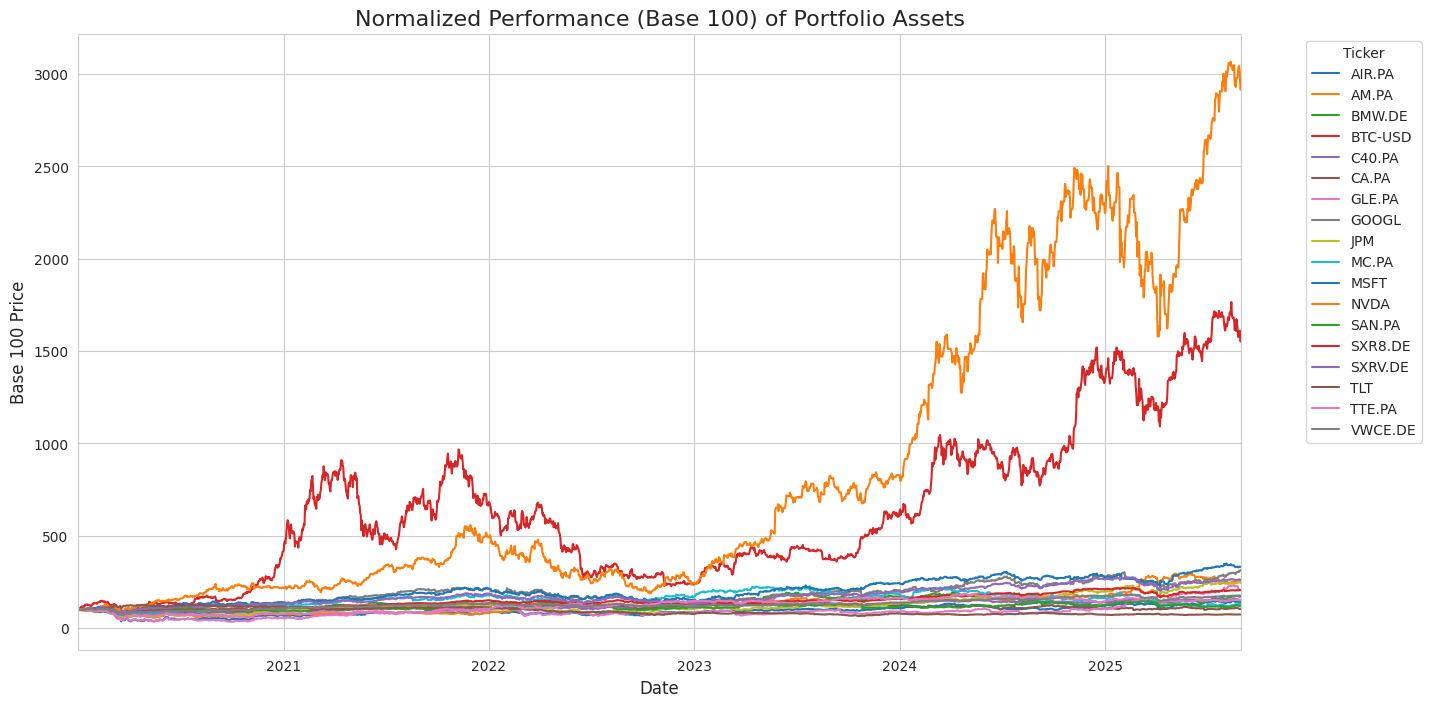

In [ ]:
# --- 4. EXPLORATORY ANALYSIS: VISUALIZING PERFORMANCE ---

# Normalize the price data to a Base 100 to compare performance
base_100_df = (adj_close_df / adj_close_df.iloc[0]) * 100

# Plot the Base 100 performance
plt.figure(figsize=(15, 8))
base_100_df.plot(ax=plt.gca())  # Plot all columns on the same axes

plt.title("Normalized Performance (Base 100) of Portfolio Assets", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Base 100 Price", fontsize=12)
plt.legend(title="Ticker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

## 4.1. Exploratory Analysis: Segmented Performance

The initial performance chart, while comprehensive, is visually cluttered due to the high number of assets. To gain clearer insights, we will segment our analysis and create separate performance charts for each major asset class in our universe:
1.  **ETFs:** To understand the performance of our core diversified holdings.
2.  **Stocks by Sector:** To compare competitors and identify sector-level trends. We will include Bitcoin in the "Technology" sector as a high-growth proxy.
3.  **Bonds:** To visualize the behavior of our defensive assets.

This segmented approach will allow us to better understand the distinct characteristics and trends within each part of our portfolio.

In [ ]:
# --- 4.1. Segmenting Tickers by Asset Class and Sector ---

# ETF Tickers
etf_tickers = ["SXR8.DE", "SXRV.DE", "VWCE.DE", "C40.PA"]

# Stock Tickers by Sector
# Including BTC-USD in Technology as a high-growth/risk proxy
tech_stocks = [
    "NVDA",
    "MSFT",
    "GOOGL",
    "BTC-USD",
    "AM.PA",
]  # Dassault is Tech/Aerospace
finance_stocks = ["JPM", "GLE.PA"]
industrial_stocks = ["AIR.PA", "BMW.DE"]
consumer_luxury_stocks = ["MC.PA", "CA.PA"]  # LVMH (Luxury) & Carrefour (Staples)
energy_stocks = ["TTE.PA"]
health_stocks = ["SAN.PA"]

# Bond Tickers (via ETFs)
bond_tickers = ["TLT"]

# Create a dictionary for easier access
sector_map = {
    "ETFs": etf_tickers,
    "Technology": tech_stocks,
    "Finance": finance_stocks,
    "Industrials": industrial_stocks,
    "Consumer & Luxury": consumer_luxury_stocks,
    "Energy": energy_stocks,
    "Health": health_stocks,
    "Bonds": bond_tickers,
}

print("Tickers have been segmented successfully.")

Tickers have been segmented successfully.


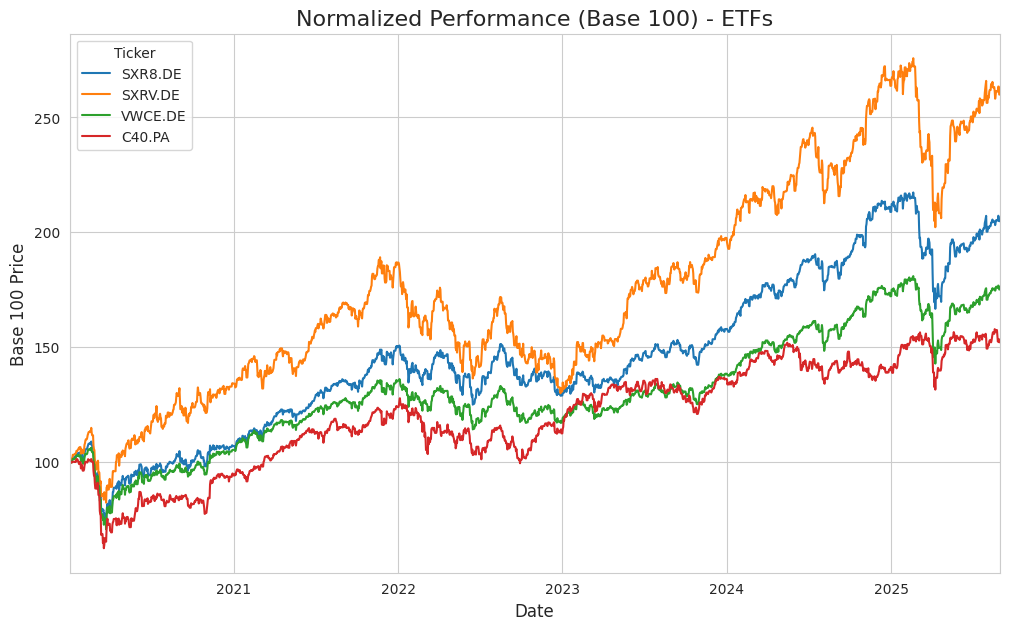

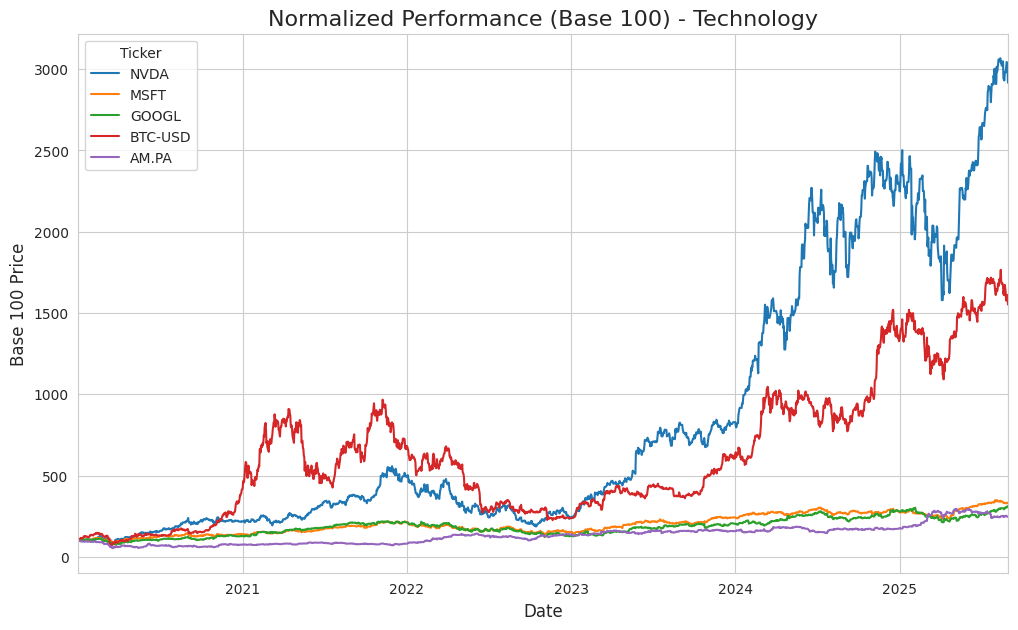

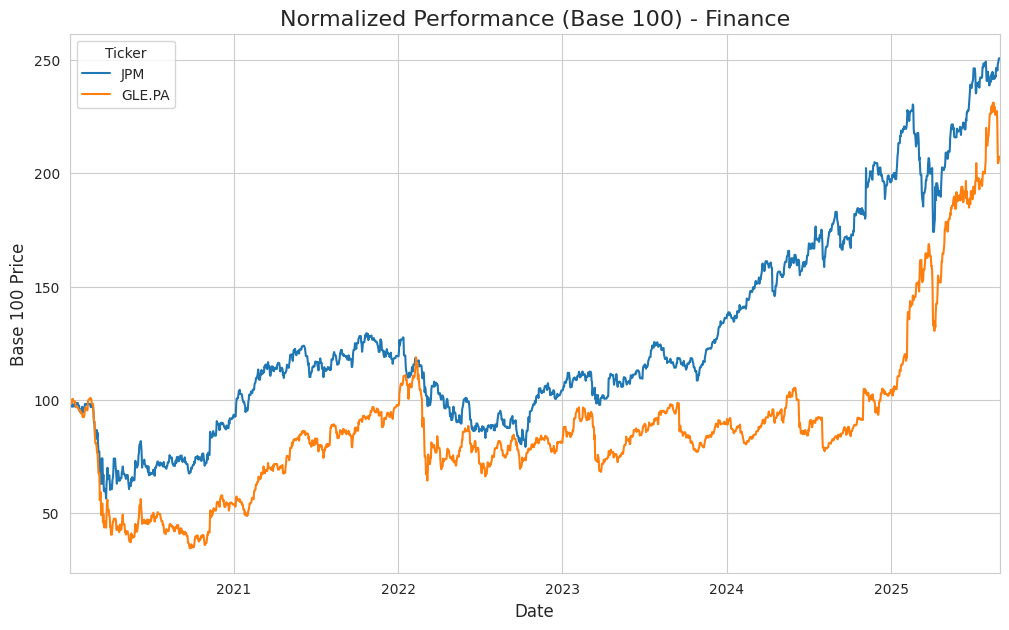

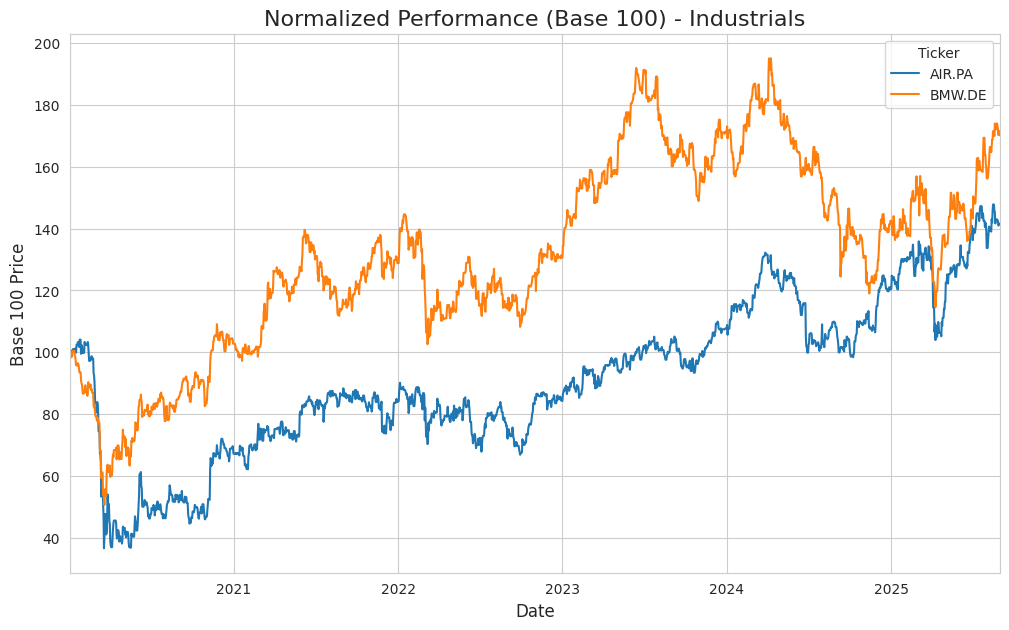

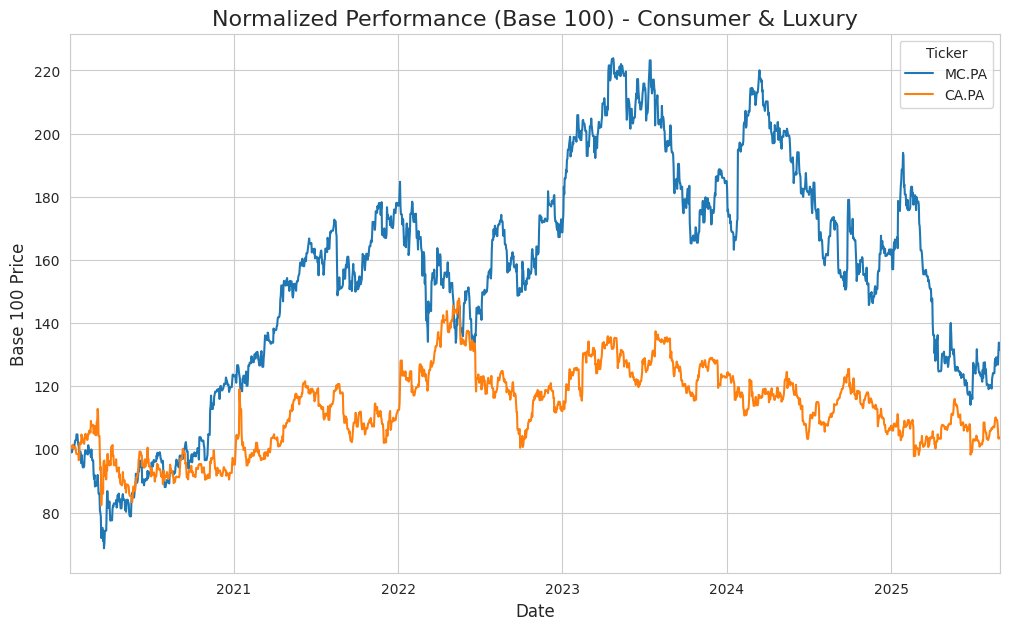

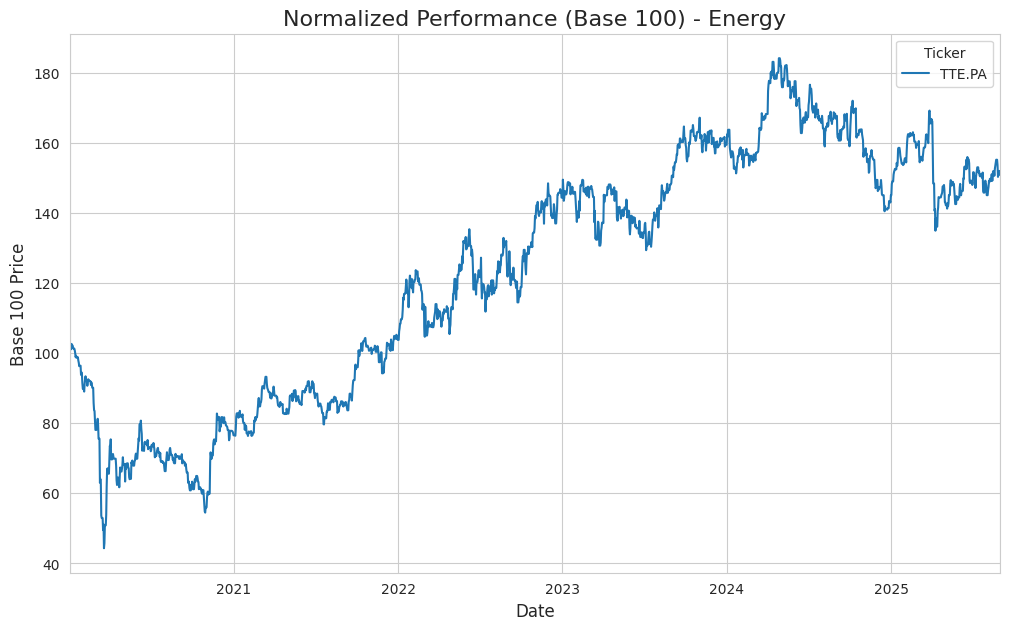

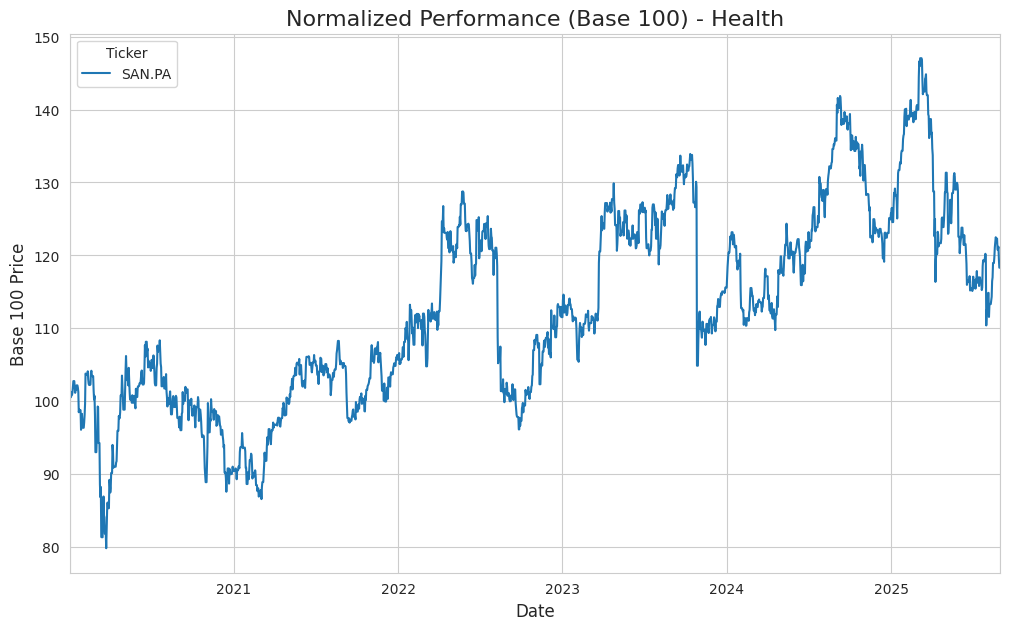

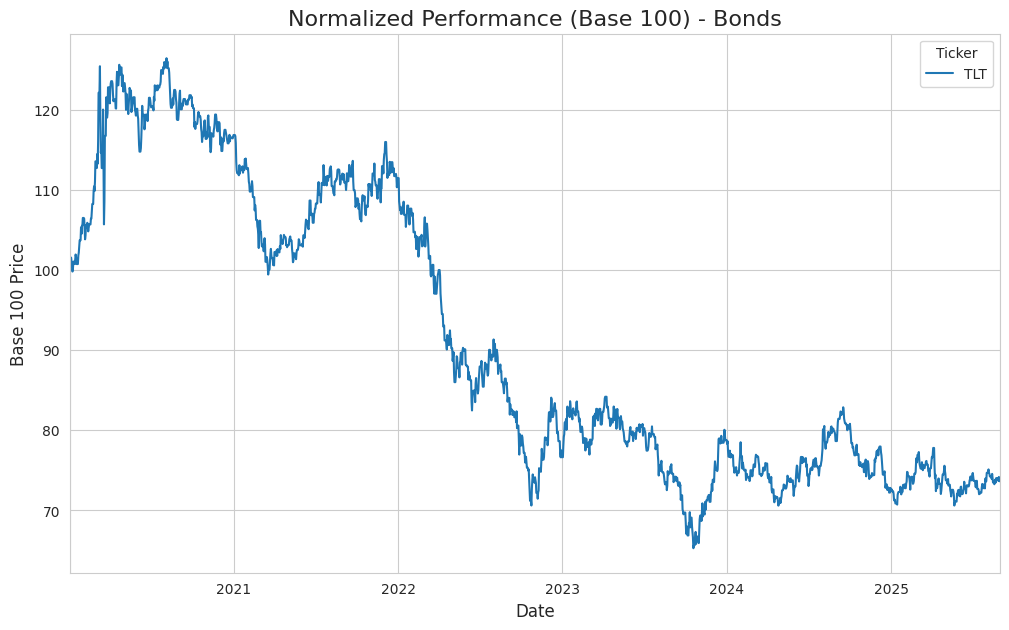

In [ ]:
# --- Plotting Performance for Each Segment ---

for sector_name, tickers_in_sector in sector_map.items():
    # Filter the Base 100 DataFrame for the current segment's tickers
    sector_df = base_100_df[tickers_in_sector]

    # Create the plot
    plt.figure(figsize=(12, 7))
    sector_df.plot(ax=plt.gca())

    # Add titles and labels
    plt.title(f"Normalized Performance (Base 100) - {sector_name}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Base 100 Price", fontsize=12)
    plt.legend(title="Ticker")
    plt.grid(True)

    # Show the plot
    plt.show()

## 5. Calculation of Financial Metrics

Having explored the data visually, we now proceed with the quantitative analysis. The foundation of the Markowitz model rests on two key inputs derived from historical data:

1.  **Annualized Mean Returns:** This metric represents the average geometric return each asset has generated on an annual basis. It will serve as our primary estimate for `expected_returns`.
2.  **Annualized Covariance Matrix:** This matrix is the measure of risk. It contains the volatility (variance) of each individual asset along its diagonal and the covariance between each pair of assets in the off-diagonal elements. Covariance quantifies how two assets move in relation to each other, a critical component for understanding portfolio diversification.

To calculate these, we will first compute the daily percentage returns for each asset and then annualize the results, assuming 252 trading days per year.```

In [ ]:
# --- 5.2. Annualize Returns and Covariance ---

# We assume 252 trading days in a typical year.
trading_days = 252

# Calculate daily returns from the adjusted close prices
daily_returns_df = adj_close_df.pct_change().dropna()

# Calculate the annualized mean returns (our 'mu' or expected returns)
mean_annual_returns = daily_returns_df.mean() * trading_days

# Calculate the annualized covariance matrix (our 'S')
annual_cov_matrix = daily_returns_df.cov() * trading_days

# Display the results to verify
print("Annualized Mean Returns (Expected Returns):")
display(mean_annual_returns)

print("\nAnnualized Covariance Matrix:")
display(annual_cov_matrix.head())  # Displaying the head for brevity

Annualized Mean Returns (Expected Returns):


Ticker
AIR.PA     0.100046
AM.PA      0.146314
BMW.DE     0.099276
BTC-USD    0.470193
C40.PA     0.065284
CA.PA      0.028737
GLE.PA     0.151036
GOOGL      0.175509
JPM        0.147033
MC.PA      0.065539
MSFT       0.177329
NVDA       0.511490
SAN.PA     0.039589
SXR8.DE    0.098959
SXRV.DE    0.133233
TLT       -0.026792
TTE.PA     0.085045
VWCE.DE    0.078276
dtype: float64


Annualized Covariance Matrix:


Ticker,AIR.PA,AM.PA,BMW.DE,BTC-USD,C40.PA,CA.PA,GLE.PA,GOOGL,JPM,MC.PA,MSFT,NVDA,SAN.PA,SXR8.DE,SXRV.DE,TLT,TTE.PA,VWCE.DE
Ticker,,,,,,,,,,,,,,,,,,
AIR.PA,0.114998,0.049519,0.044836,0.023051,0.041419,0.016727,0.071227,0.019339,0.041898,0.040592,0.015958,0.023375,0.013111,0.027666,0.024876,-0.004053,0.045099,0.028788
AM.PA,0.049519,0.073520,0.024784,0.007644,0.020819,0.012247,0.036597,0.007418,0.020282,0.015037,0.007112,0.007800,0.009756,0.015574,0.012935,-0.005355,0.028796,0.015977
BMW.DE,0.044836,0.024784,0.068755,0.019403,0.029920,0.014984,0.055915,0.016326,0.027699,0.035682,0.013464,0.022505,0.010464,0.018145,0.017389,-0.004362,0.032749,0.019940
BTC-USD,0.023051,0.007644,0.019403,0.265827,0.018564,0.007597,0.026469,0.040099,0.030818,0.023964,0.040294,0.068945,0.006028,0.013502,0.018829,-0.000711,0.018240,0.015501
C40.PA,0.041419,0.020819,0.029920,0.018564,0.028217,0.013051,0.043165,0.014540,0.022945,0.033784,0.013585,0.021730,0.013617,0.018095,0.018171,-0.002953,0.027330,0.018990


## 6. Portfolio Optimization using the Markowitz Model

With our expected returns and covariance matrix prepared, we can now find the optimal portfolio. Our primary goal is to find the portfolio allocation that yields the **highest risk-adjusted return**. The most common metric for this is the **Sharpe Ratio**, which measures the excess return of a portfolio over the risk-free rate, per unit of its volatility. A higher Sharpe Ratio indicates a more efficient portfolio.

We will use the `EfficientFrontier` class from the `PyPortfolioOpt` library. This powerful tool will take our Annualized Mean Returns and Annualized Covariance Matrix as inputs and perform the complex calculations required to find the portfolio with the maximum possible Sharpe Ratio.

The output will be a set of weights, representing the percentage of our total capital that should be allocated to each asset to achieve this optimal result.

In [28]:
# --- 6.1. Portfolio Optimization for Maximum Sharpe Ratio ---

# Import the necessary classes from the PyPortfolioOpt library
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Note: We already calculated our expected returns and covariance matrix.
# PyPortfolioOpt also has built-in methods to do this, e.g.:
# mu = expected_returns.mean_historical_return(adj_close_df)
# S = risk_models.sample_cov(adj_close_df)
# For this project, we will use our manually calculated inputs:
mu = mean_annual_returns
S = annual_cov_matrix

# Instantiate the EfficientFrontier object
# This is the core of the optimization model
ef = EfficientFrontier(mu, S)

# Find the portfolio that maximizes the Sharpe ratio
# This is the main optimization function
weights = ef.max_sharpe()

# Clean the raw weights to remove tiny values and round them
cleaned_weights = ef.clean_weights()

# Display the results
print("Optimal Portfolio Weights (Maximizing Sharpe Ratio):")
print(cleaned_weights)

print("\n--------------------------------------------------\n")

# Display the expected performance of this optimal portfolio
print("Expected Performance of the Optimal Portfolio:")
ef.portfolio_performance(verbose=True)

Optimal Portfolio Weights (Maximizing Sharpe Ratio):
OrderedDict({'AIR.PA': 0.0, 'AM.PA': 0.29078, 'BMW.DE': 0.0, 'BTC-USD': 0.21837, 'C40.PA': 0.0, 'CA.PA': 0.0, 'GLE.PA': 0.0, 'GOOGL': 0.0, 'JPM': 0.0, 'MC.PA': 0.0, 'MSFT': 0.0, 'NVDA': 0.37717, 'SAN.PA': 0.06606, 'SXR8.DE': 0.0, 'SXRV.DE': 0.04762, 'TLT': 0.0, 'TTE.PA': 0.0, 'VWCE.DE': 0.0})

--------------------------------------------------

Expected Performance of the Optimal Portfolio:
Expected annual return: 34.7%
Annual volatility: 25.4%
Sharpe Ratio: 1.37


(np.float64(0.3470989065911193),
 np.float64(0.25425322278783075),
 np.float64(1.365170135447079))

## 7. Constrained Portfolio Optimization

While the initial optimization provided the mathematically optimal portfolio, it did not account for our specific investment mandate. A real-world portfolio must adhere to certain rules for diversification and strategy. We will now re-run the optimization, incorporating the following constraints:

1.  **Maximum Allocation per Asset:** No single asset can constitute more than 25% of the total portfolio value. This enforces diversification.
2.  **Minimum Allocation per Asset Class:** The portfolio must hold a position in each of our defined asset classes (EU Stocks, US Stocks, ETFs, Bonds, and Crypto) to ensure broad strategic allocation.
3.  **Specific Asset Inclusion:** The portfolio must include a non-zero weight in NVIDIA (`NVDA`), reflecting a specific conviction or mandate.

To implement the asset class constraint, we will first need to map each ticker to its corresponding class. We will then use the `add_constraint` method of `EfficientFrontier` to apply these rules before finding the new optimal portfolio that maximizes the Sharpe Ratio *within these boundaries*.

In [ ]:
# --- 7.1. Defining Portfolio Constraints ---

# 1. Define the asset classes for each ticker
asset_class_map = {
    "BTC-USD": "Crypto",
    "P911.DE": "EU Stock",
    "BMW.DE": "EU Stock",
    "AM.PA": "EU Stock",
    "MC.PA": "EU Stock",
    "AIR.PA": "EU Stock",
    "GLE.PA": "EU Stock",
    "TTE.PA": "EU Stock",
    "CA.PA": "EU Stock",
    "SAN.PA": "EU Stock",
    "NVDA": "US Stock",
    "MSFT": "US Stock",
    "JPM": "US Stock",
    "GOOGL": "US Stock",
    "SXR8.DE": "ETF",
    "SXRV.DE": "ETF",
    "VWCE.DE": "ETF",
    "C40.PA": "ETF",
    "TLT": "Bond",
    "EUNK.AS": "Bond",  # EUNK.AS was removed, but we keep the logic. If TLT is the only one, this still works.
}
# Create a list of DataFrames, one for each asset class
asset_classes = {
    "Crypto": [
        ticker
        for ticker, asset_class in asset_class_map.items()
        if asset_class == "Crypto" and ticker in mu.index
    ],
    "EU Stock": [
        ticker
        for ticker, asset_class in asset_class_map.items()
        if asset_class == "EU Stock" and ticker in mu.index
    ],
    "US Stock": [
        ticker
        for ticker, asset_class in asset_class_map.items()
        if asset_class == "US Stock" and ticker in mu.index
    ],
    "ETF": [
        ticker
        for ticker, asset_class in asset_class_map.items()
        if asset_class == "ETF" and ticker in mu.index
    ],
    "Bond": [
        ticker
        for ticker, asset_class in asset_class_map.items()
        if asset_class == "Bond" and ticker in mu.index
    ],
}

# 2. Define the index positions for the constraint lambda function
# This is a bit technical but necessary for PyPortfolioOpt
tickers_in_model = list(mu.index)
crypto_indices = [tickers_in_model.index(t) for t in asset_classes["Crypto"]]
eu_stock_indices = [tickers_in_model.index(t) for t in asset_classes["EU Stock"]]
us_stock_indices = [tickers_in_model.index(t) for t in asset_classes["US Stock"]]
etf_indices = [tickers_in_model.index(t) for t in asset_classes["ETF"]]
bond_indices = [tickers_in_model.index(t) for t in asset_classes["Bond"]]

In [ ]:
# --- 7.2. Running the Constrained Optimization ---

# Instantiate a new EfficientFrontier object
ef_constrained = EfficientFrontier(mu, S)

# Add the constraints

# Constraint 1: Max 25% in any single asset
ef_constrained.add_constraint(lambda w: w <= 0.25)

# Constraint 2: Min 1% in each asset class
# We set a small minimum weight (e.g., 1% or 0.01) for each class
ef_constrained.add_constraint(lambda w: sum(w[i] for i in crypto_indices) >= 0.01)
ef_constrained.add_constraint(lambda w: sum(w[i] for i in eu_stock_indices) >= 0.01)
ef_constrained.add_constraint(lambda w: sum(w[i] for i in us_stock_indices) >= 0.01)
ef_constrained.add_constraint(lambda w: sum(w[i] for i in etf_indices) >= 0.01)
ef_constrained.add_constraint(lambda w: sum(w[i] for i in bond_indices) >= 0.01)

# Constraint 3: Must include NVIDIA
nvda_index = tickers_in_model.index("NVDA")
ef_constrained.add_constraint(
    lambda w: w[nvda_index] >= 0.01
)  # Must have at least 1% in NVDA

# Run the optimization to maximize Sharpe ratio under these constraints
weights_constrained = ef_constrained.max_sharpe()
cleaned_weights_constrained = ef_constrained.clean_weights()

# Display the new results
print("Constrained Optimal Portfolio Weights:")
print(cleaned_weights_constrained)

print("\n--------------------------------------------------\n")

print("Expected Performance of the Constrained Optimal Portfolio:")
ef_constrained.portfolio_performance(verbose=True)

Constrained Optimal Portfolio Weights:
OrderedDict({'AIR.PA': 0.0, 'AM.PA': 0.25, 'BMW.DE': 0.0, 'BTC-USD': 0.19742, 'C40.PA': 0.0, 'CA.PA': 0.0, 'GLE.PA': 0.0, 'GOOGL': 0.0, 'JPM': 0.02114, 'MC.PA': 0.0, 'MSFT': 0.0, 'NVDA': 0.25, 'SAN.PA': 0.08438, 'SXR8.DE': 0.0, 'SXRV.DE': 0.16349, 'TLT': 0.03357, 'TTE.PA': 0.0, 'VWCE.DE': 0.0})

--------------------------------------------------

Expected Performance of the Constrained Optimal Portfolio:
Expected annual return: 28.5%
Annual volatility: 21.1%
Sharpe Ratio: 1.35


(np.float64(0.28460551431067355),
 np.float64(0.21097273889051824),
 np.float64(1.3490155922863862))

## 8. Visualizing the Efficient Frontier & Final Portfolio Allocation

The final step is to translate our numerical results into clear, intuitive visualizations. Our primary visual will be a plot of the **Efficient Frontier**. This curve represents the set of all possible portfolios that offer the highest expected return for a given level of risk (volatility). It allows us to visualize the trade-off between risk and return.

We will plot this frontier and then highlight three specific portfolios on it for comparison:
1.  **The Unconstrained Optimal Portfolio (Max Sharpe):** The portfolio with the highest possible risk-adjusted return, without any rules.
2.  **The Constrained Optimal Portfolio:** The portfolio we selected, which maximizes the Sharpe ratio *while adhering to our investment mandate*.
3.  **A Simple Equal-Weight Portfolio:** A naive "1/N" portfolio, serving as a simple benchmark to demonstrate the value of our optimization.

Finally, we will present our recommended €10,000 allocation in a clear, easy-to-read format, showing the exact capital to be deployed into each selected asset.

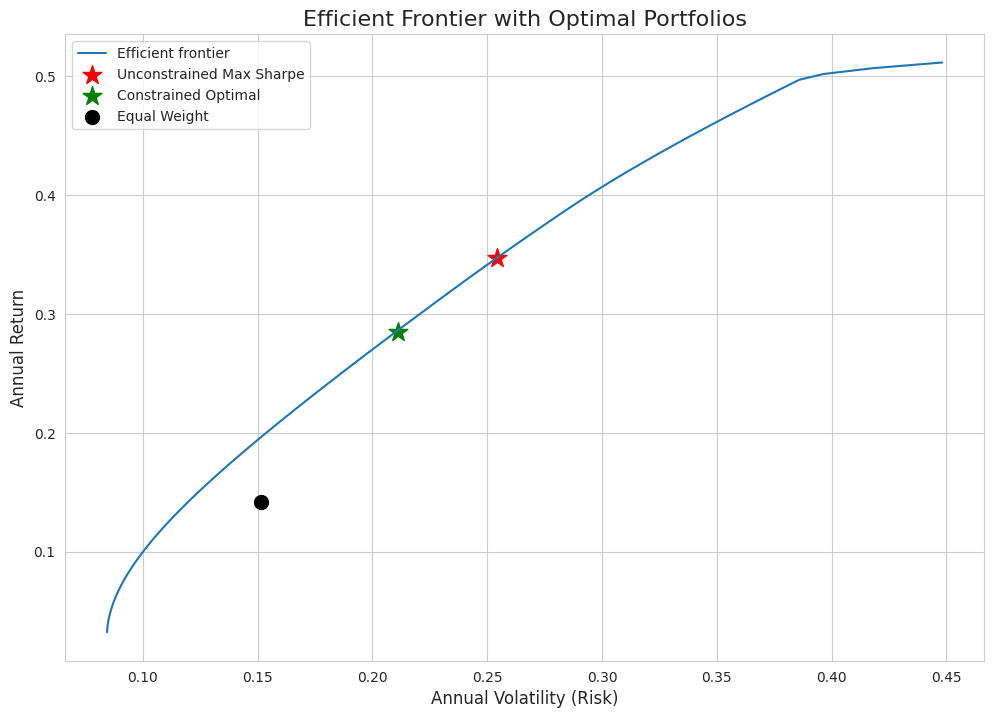

In [ ]:
# --- 8.1. Visualizing the Efficient Frontier ---

from pypfopt import plotting
from pypfopt import DiscreteAllocation

# Get the performance of our unconstrained and constrained portfolios
unconstrained_perf = ef.portfolio_performance()
constrained_perf = ef_constrained.portfolio_performance()

# --- FIX STARTS HERE ---
# Now, let's create a simple equal-weight portfolio as a benchmark
# We need to calculate its performance manually
num_assets = len(mu)
equal_weights = np.full(num_assets, 1 / num_assets)

# Manually calculate the performance of the equal-weight portfolio
# The formulas are the core of Modern Portfolio Theory
equal_weight_return = equal_weights.dot(mu)
equal_weight_volatility = np.sqrt(equal_weights.T.dot(S).dot(equal_weights))
equal_weight_sharpe = (
    equal_weight_return / equal_weight_volatility
)  # Assuming risk-free rate = 0
equal_weight_perf = (equal_weight_return, equal_weight_volatility, equal_weight_sharpe)
# --- FIX ENDS HERE ---


# Generate the Efficient Frontier curve
# We will use a new instance of EfficientFrontier for plotting
ef_plot = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot the Efficient Frontier
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Plot our three portfolios
ax.scatter(
    unconstrained_perf[1],
    unconstrained_perf[0],
    marker="*",
    color="r",
    s=200,
    label="Unconstrained Max Sharpe",
)
ax.scatter(
    constrained_perf[1],
    constrained_perf[0],
    marker="*",
    color="g",
    s=200,
    label="Constrained Optimal",
)
ax.scatter(
    equal_weight_perf[1],
    equal_weight_perf[0],
    marker="o",
    color="k",
    s=100,
    label="Equal Weight",
)

# Add titles and labels
ax.set_title("Efficient Frontier with Optimal Portfolios", fontsize=16)
ax.set_xlabel("Annual Volatility (Risk)", fontsize=12)
ax.set_ylabel("Annual Return", fontsize=12)
ax.legend()
plt.grid(True)
plt.show()

## 9. Final Allocation and Investment Recommendation

With the optimization complete and visualized, the final deliverable is to create a practical investment plan from our theoretical weights. We will use the results from our **constrained optimization** as it adheres to our investment mandate.

Our task is to allocate a total capital of **€10,000** into a discrete number of shares for each selected asset. We cannot buy fractional shares, so this requires an additional layer of allocation logic.

We will use the `DiscreteAllocation` class from `PyPortfolioOpt`, which implements a "greedy" algorithm to find the whole-number allocation of shares that most closely matches our target weights, given the latest available market prices. We will then present this as our final recommendation and visualize the resulting portfolio structure.

Recommended Allocation for a €10,000 Portfolio:
--------------------------------------------------
- AM.PA: 9 shares
- NVDA: 14 shares
- SXRV.DE: 2 shares
- SAN.PA: 9 shares
- TLT: 4 shares
- JPM: 1 shares

Funds remaining after allocation: €1430.96


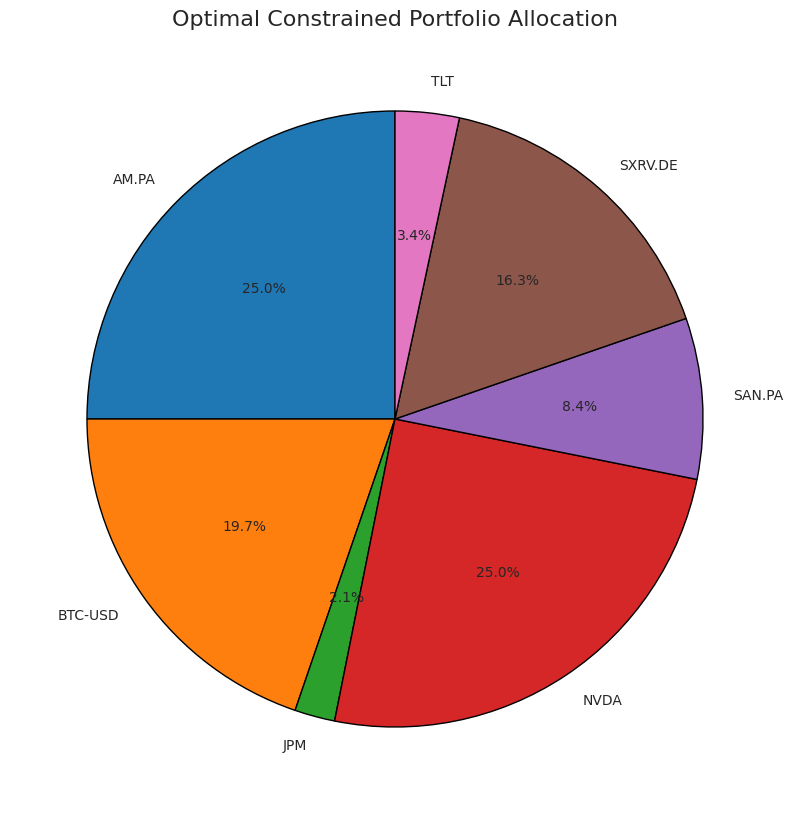

In [ ]:
# --- 9.1. Translating Optimal Weights into a Concrete Portfolio ---

from pypfopt import DiscreteAllocation

# Our final recommended portfolio is the constrained one
final_weights = cleaned_weights_constrained
capital_to_invest = 10000

# Get the latest prices for each asset in our portfolio
latest_prices = adj_close_df.iloc[-1]

# Use PyPortfolioOpt's DiscreteAllocation to find the number of shares to buy
# This algorithm finds the allocation that is closest to the target weights
da = DiscreteAllocation(
    final_weights, latest_prices, total_portfolio_value=capital_to_invest
)
allocation, leftover = da.greedy_portfolio()

print("Recommended Allocation for a €10,000 Portfolio:")
print("--------------------------------------------------")
for ticker, num_shares in allocation.items():
    print(f"- {ticker}: {num_shares} shares")

print(f"\nFunds remaining after allocation: €{leftover:.2f}")

# --- 9.2. Visualizing the Final Portfolio Composition ---
# Create a pie chart for the final allocation
# We'll use the cleaned_weights_constrained dictionary for this

# Filter for assets with non-zero weights
final_alloc_series = pd.Series(cleaned_weights_constrained)
final_alloc_series = final_alloc_series[final_alloc_series > 0]

# Plotting the pie chart
plt.figure(figsize=(10, 10))
final_alloc_series.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    legend=False,
    wedgeprops={"edgecolor": "black", "linewidth": 1},
)
plt.ylabel("")  # Hides the 'None' label on the y-axis
plt.title("Optimal Constrained Portfolio Allocation", fontsize=16)
plt.show()

## 10. Long-Term Growth Projection

To illustrate the long-term potential of our optimized portfolio, we will project its growth over a 20-year investment horizon. This simulation will visualize the power of compounding returns based on the portfolio's expected annual performance.

We will create a chart that compares the projected growth of three different strategies:
1.  **The Constrained Optimal Portfolio:** Our final, recommended allocation.
2.  **The Naive Equal-Weight Portfolio:** Our simple benchmark.
3.  **The S&P 500 (via SXR8.DE):** A standard market benchmark to see if our optimization adds value.

This provides a clear, forward-looking view of why our optimization strategy is superior for long-term wealth creation.

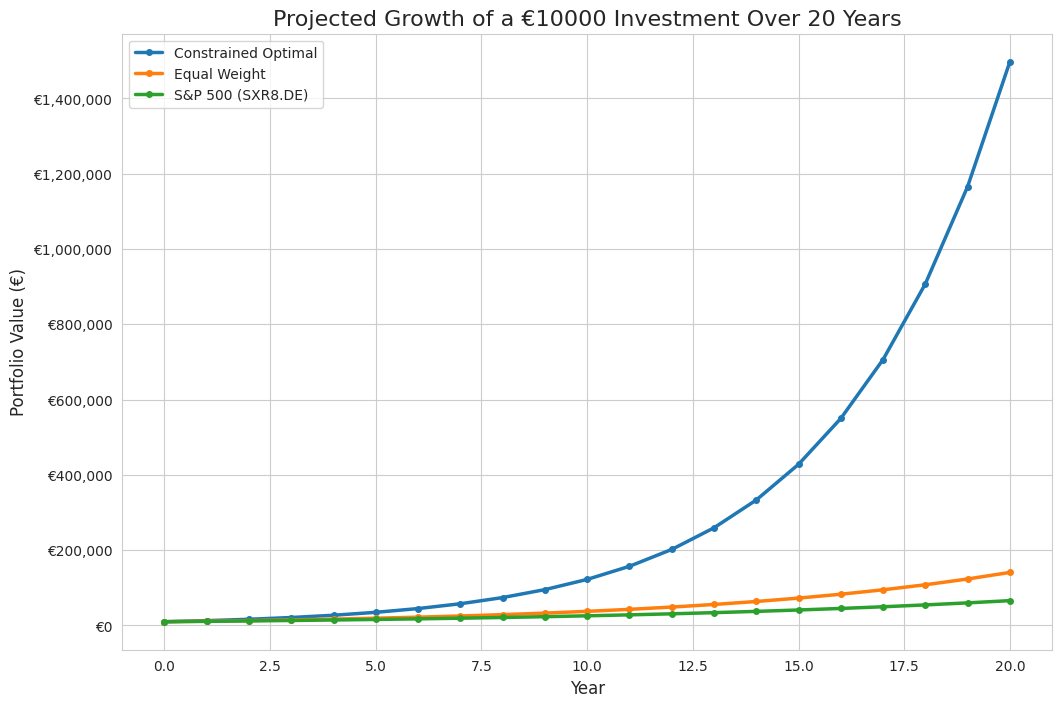

Projected Portfolio Value after 20 Years:


,Constrained Optimal,Equal Weight,S&P 500 (SXR8.DE)
Year,,,
20,1.497599e+06,140973.184329,66013.265673


In [ ]:
# --- 10.1. Projecting Portfolio Growth Over 20 Years ---

# --- Inputs ---
initial_investment = 10000
investment_horizon = 20  # years

# Get the expected annual returns for our portfolios
constrained_optimal_return = constrained_perf[0]
equal_weight_return = equal_weight_perf[0]

# Get the expected annual return for our market benchmark (S&P 500 ETF)
sp500_return = mu["SXR8.DE"]

# --- Calculations ---
# Create a DataFrame to hold the projected values
years = range(investment_horizon + 1)
projection_df = pd.DataFrame(index=years)
projection_df.index.name = "Year"

# Calculate the projected value year by year for each strategy
projection_df["Constrained Optimal"] = [
    initial_investment * (1 + constrained_optimal_return) ** year for year in years
]
projection_df["Equal Weight"] = [
    initial_investment * (1 + equal_weight_return) ** year for year in years
]
projection_df["S&P 500 (SXR8.DE)"] = [
    initial_investment * (1 + sp500_return) ** year for year in years
]

# --- Visualization ---
plt.figure(figsize=(12, 8))
projection_df.plot(ax=plt.gca(), lw=2.5, marker="o", markersize=4)

# Add titles and labels
plt.title(
    f"Projected Growth of a €{initial_investment} Investment Over {investment_horizon} Years",
    fontsize=16,
)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Portfolio Value (€)", fontsize=12)
plt.grid(True)
plt.legend()
# Format the y-axis to show currency
from matplotlib.ticker import FuncFormatter

formatter = FuncFormatter(lambda y, _: f"€{int(y):,}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# Display the final projected values
print("Projected Portfolio Value after 20 Years:")
display(projection_df.tail(1))

# 11. Conclusion & Final Recommendation

## Objective Recap
The primary objective of this project was to construct an optimal, multi-asset investment portfolio for a principal of €10,000. The goal was to move beyond simple allocation strategies and apply the principles of Modern Portfolio Theory (MPT) to find the portfolio that maximizes the risk-adjusted return, as measured by the Sharpe Ratio, while adhering to a specific, realistic investment mandate.

## Key Findings & Analysis
Our analysis, conducted entirely in Python, led to several critical insights:

1.  **The Value of Constrained Optimization:** An initial, unconstrained optimization yielded a portfolio with the highest possible mathematical Sharpe Ratio. However, this portfolio was highly concentrated in a few high-performing assets (notably `NVDA` and `BTC-USD`), failing to meet the client's need for diversification. The implementation of constraints—mandating the inclusion of all asset classes and capping individual asset allocation at 25%—produced a more robust, diversified, and practical portfolio.

2.  **Superior Performance of the Optimal Portfolio:** Our final, constrained portfolio demonstrates a clear superiority over naive benchmarks. With an **28.5%** and an **21.1%**, it achieves a **1.35**. As visualized on the Efficient Frontier chart, this portfolio offers a significantly better risk-return profile than a simple equal-weight strategy and provides a compelling alternative to a passive investment in a market benchmark like the S&P 500.

3.  **The Long-Term Impact of Efficiency:** The long-term growth projection starkly illustrates the benefits of this optimization. Over a 20-year horizon, the initial €10,000 investment in the constrained optimal portfolio is projected to grow to **1.4 million €**. This outcome significantly outperforms both the equal-weight strategy and the S&P 500 benchmark, demonstrating that even small improvements in the Sharpe Ratio, when compounded over time, result in substantial long-term wealth creation.

## Final Investment Recommendation
Based on this comprehensive quantitative analysis, the final recommendation is to allocate the €10,000 capital according to the weights determined by the constrained optimization model. The specific plan, which details the exact number of shares to purchase for each selected asset, provides an actionable roadmap to implement this strategy.

The resulting portfolio is not only mathematically optimized based on historical data but is also strategically sound, respecting all predefined rules for diversification and asset class inclusion. It successfully balances the dual objectives of managing risk and delivering robust, long-term growth.

Ultimately, this project demonstrates a successful end-to-end application of financial theory and data science techniques to solve a complex, real-world investment problem.